This notebook demonstrates an `unpaired` image-to-image translation using a conditional GANs, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), which is also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics apply to another image domain without any paired examples.

This notebook or code for CycleGAN is similar to [Pix2Pix](./TF2Keras_Pix2Pix.ipynb), which is an example for `paired` image-to-image translation. The difference are the additional loss function and the use of unpaired data.

CycleGAN proposes a `cycle consistent loss function` to enable the training without the paired data. In other words, it can translate from one image domain to another one without the one-to-one mapping between the source and the target domain.

The following are examples.

![](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_1.png)
- from Tensorflow.org (2020)


![](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_2.png)
- from Tensorflow.org (2020)

In [ ]:
!pip uninstall -y tensorflow
!pip install -q --no-cache-dir tf-nightly tfds-nightly tensorflow_addons

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow_addons as tfa

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Tensorflow Version: {}".format(tf.__version__))
if tf.config.list_physical_devices("GPU"):
  print("GPU is available.")

  from tensorflow.python.client import device_lib
  print(device_lib.list_local_devices())
else:
  print("GPU is not available.")

Tensorflow Version: 2.4.0-dev20200720
GPU is available.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7525332843561979411
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14643957478470472966
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10971491098633345682
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11132984384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6012150760239873030
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Setup the Input Pipeline

This tutorial trains a model translating images of horses to images of zebras. You can find the dataset from the [Tensorflow Dataset](https://www.tensorflow.org/datasets/catalog/overview#cycle_gan).

Based on the [paper of Pix2Pix](https://arxiv.org/abs/1611.07004) provided, the data augmentation techniques are taken.
* random jittering: resize the image to `286x286` and randomly crop the image to `256x256`
* random mirroring: flip horizontally

In [3]:
dataset, metadata = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteICN8QE/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteICN8QE/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteICN8QE/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteICN8QE/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [4]:
metadata

tfds.core.DatasetInfo(
    name='cycle_gan',
    version=2.0.0,
    description='A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)',
    homepage='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=2661,
    splits={
        'testA': 120,
        'testB': 140,
        'trainA': 1067,
        'trainB': 1334,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/ZhuPIE17,
      author    = {Jun{-}Yan Zhu and
                   Taesung Park and
                   Phillip Isola and
                   Alexei A. Efros},
      title     = {Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial
                   Networks},
      journal   = {CoRR},
      volume    = {abs/1703.10593},

In [5]:
dataset

{'testA': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'testB': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainA': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainB': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [6]:
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [7]:
for test_image, test_label in test_horses.take(3):
  print(test_image.shape, test_label.shape, test_label.numpy())

(256, 256, 3) () 0
(256, 256, 3) () 0
(256, 256, 3) () 0


In [8]:
BUFFERSIZE = 1000
BATCHSIZE = 1
IMGWIDTH = 256
IMGHEIGHT = 256
IMGCHANNEL = 3

In [9]:
def random_jitter(images):
  # resize to 286 x 286
  images = tf.image.resize(images, size=[286, 286], 
                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # random crop
  images = tf.image.random_crop(images, size=[IMGWIDTH, IMGHEIGHT, IMGCHANNEL])

  # random flip horizontally
  images = tf.image.random_flip_left_right(images)
  return images

In [10]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images = (images / 127.5) - 1
  return images

Here the labels in the dataset are not necessary. However, to keep the dataset structure simple we still load the dataset with `as_supervised=True` to load the labels but ignore them in the data pipeline. 

In [11]:
def process_train_images(images, labels):
  images = random_jitter(images)
  images = normalize(images)
  return images

In [12]:
def process_test_image(images, labels):
  images = normalize(images)
  return images

In [13]:
train_horses = train_horses.map(process_train_images, num_parallel_calls=AUTOTUNE
                                ).cache().shuffle(BUFFERSIZE).batch(BATCHSIZE)
train_zebras = train_zebras.map(process_train_images, num_parallel_calls=AUTOTUNE
                                ).cache().shuffle(BUFFERSIZE).batch(BATCHSIZE)

test_horses = test_horses.map(process_test_image, num_parallel_calls=AUTOTUNE
                              ).cache().shuffle(BUFFERSIZE).batch(BATCHSIZE)
test_zebras = test_zebras.map(process_test_image, num_parallel_calls=AUTOTUNE
                              ).cache().shuffle(BUFFERSIZE).batch(BATCHSIZE)

Show some examples.

In [14]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

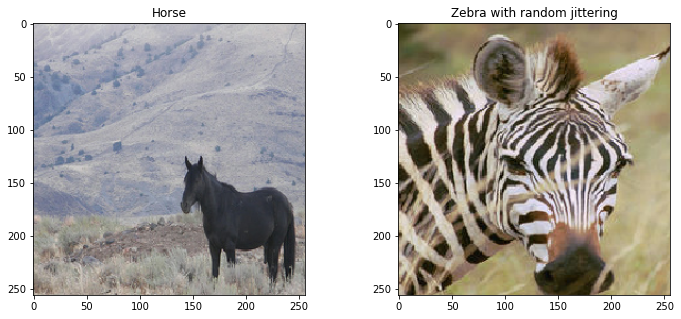

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Horse")
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title('Zebra with random jittering')
plt.imshow(random_jitter(sample_zebra[0] * 0.5 + 0.5))

plt.show()

# Define the CycleGAN Model

The CycleGAN model is similar to Pix2Pix's one. The following we first create the Generator and the Discriminator models.

## Downsample Block

In [16]:
def down_sample(filters, size, applyInstancenorm=True):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=filters, 
                                   kernel_size=size, 
                                   strides=(2, 2), 
                                   padding="same", 
                                   kernel_initializer=initializer))
  
  if applyInstancenorm:
    model.add(tfa.layers.InstanceNormalization(epsilon=1e-6))

  model.add(tf.keras.layers.LeakyReLU())
  return model

In [17]:
ds = down_sample(32, 4)
ds_output = ds(sample_horse)
print(sample_horse.shape, ds_output.shape)

(1, 256, 256, 3) (1, 128, 128, 32)


## Upsample Block

In [18]:
def up_sample(filters, size, applyDropout=False):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2DTranspose(filters=filters,
                                            kernel_size=size,
                                            strides=(2, 2),
                                            padding="same",
                                            kernel_initializer=initializer))
  
  model.add(tfa.layers.InstanceNormalization(epsilon=1e-6))

  if applyDropout:
    model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(tf.keras.layers.ReLU())
  return model

In [19]:
us = up_sample(128, 4)
us_output = us(ds_output)
print(ds_output.shape, us_output.shape)

(1, 128, 128, 32) (1, 256, 256, 128)


## Generator

To build the generator `CycleGAN` uses `Resnet` as the backbone, here we refer to the generator defined in Pix2Pix. The differences between them are using the Instance Normalization instead of the Batch Normalization. (The `CycleGAN` used the Instance Normalization in the paper.)

**The generator is the final model or product while production**. You can simply switch the backbone to other architectures, like `U-Net`, etc.

In [20]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # down sample layers
  down_sample_layers = [ \
    down_sample(64, 4, False),    # [128, 128, 64]
    down_sample(128, 4),          # [64, 64, 128]
    down_sample(256, 4),          # [32, 32, 256]
    down_sample(512, 4),          # [16, 16, 512]
    down_sample(512, 4),          # [8, 8, 512]
    down_sample(512, 4),          # [4, 4, 512]
    down_sample(512, 4),          # [2, 2, 512]
    down_sample(512, 4),          # [1, 1, 512]
  ]

  # up sample layers
  up_sample_layers = [ \
    up_sample(512, 4, True),      # [2, 2, 512] -> [2, 2, 512+512]
    up_sample(512, 4, True),      # [4, 4, 512] -> [4, 4, 512+512]
    up_sample(512, 4, True),      # [8, 8, 512] -> [8, 8, 512+512]
    up_sample(512, 4),            # [16, 16, 512] -> [16, 16, 512+512]
    up_sample(256, 4),            # [32, 32, 256] -> [32, 32, 256+256]
    up_sample(128, 4),            # [64, 64, 128] -> [64, 64, 128+128]
    up_sample(64, 4),             # [128, 128, 64] -> [128, 128, 64+64]
  ]

  # last layer
  last_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)
  last = tf.keras.layers.Conv2DTranspose(filters=3, 
                                         kernel_size=4, 
                                         strides=(2, 2),
                                         padding="same",
                                         activation='tanh',
                                         kernel_initializer=last_initializer)
  
  # build the model
  skips = []
  x = inputs
  for dsl in down_sample_layers:
    x = dsl(x)
    skips.append(x)

  skips = skips[:-1][::-1]   # reverse the layer output for connection

  for uslIdx in range(len(up_sample_layers)):
    x = up_sample_layers[uslIdx](x)
    x = tf.keras.layers.Concatenate()([x, skips[uslIdx]])
  
  outputs = last(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

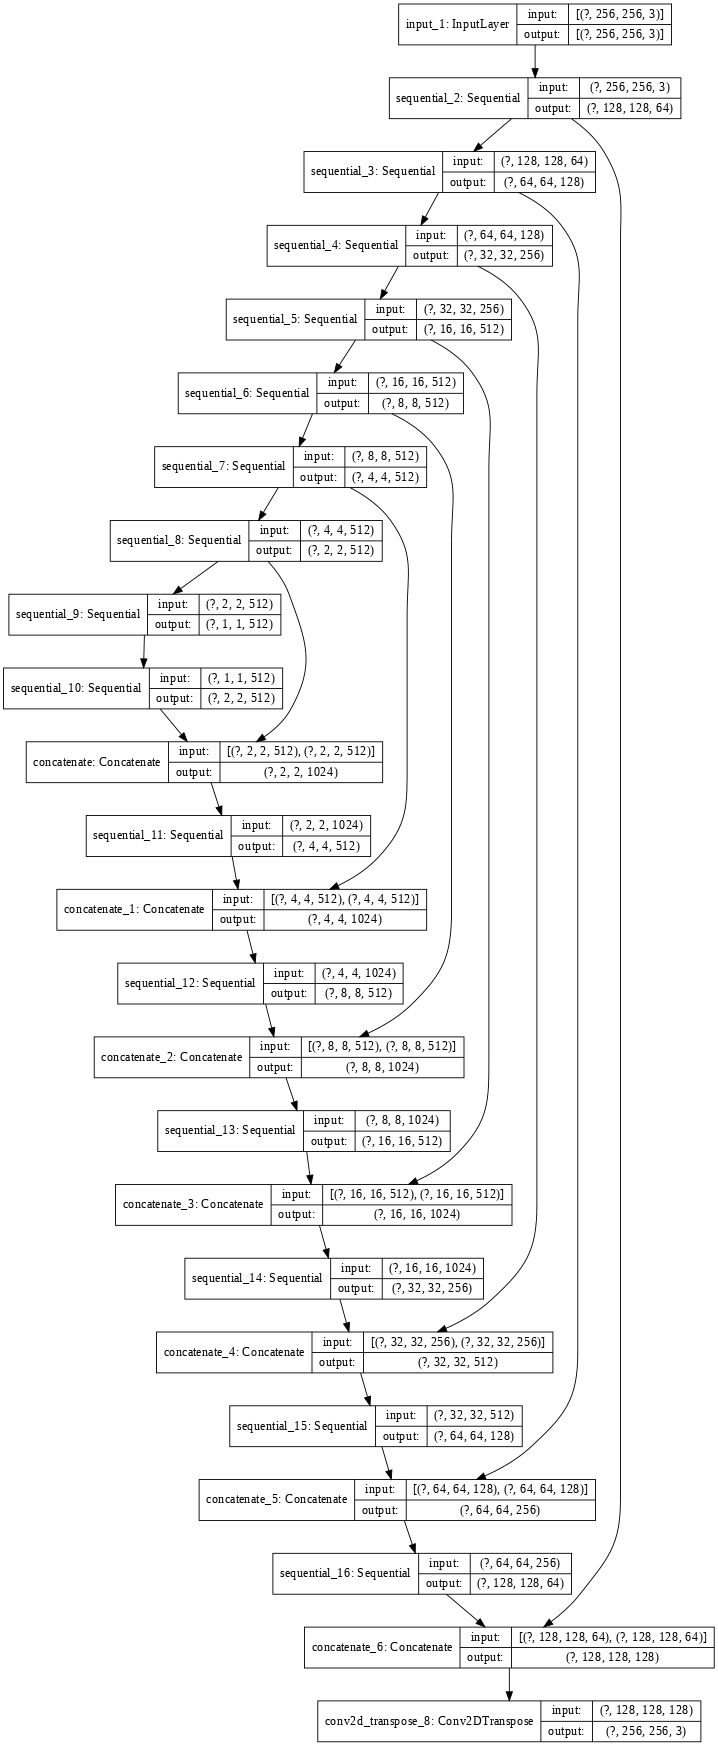

In [21]:
example_gen = Generator()
tf.keras.utils.plot_model(example_gen, show_shapes=True, dpi=64)

## Discriminator

The discriminator is a PatchGAN. Each block in a 30x30 patch represents a corresponding block in an original 256x256 image.

In [22]:
def Discriminator(target=True):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)

  inp = tf.keras.layers.Input(shape=[256, 256, 3])

  if target:
    tgt = tf.keras.layers.Input(shape=[256, 256, 3])
    concatenation = tf.keras.layers.Concatenate()([inp, tgt]) # [256, 256, 3+3]
  else:
    concatenation = inp

  x = down_sample(64, 4, False)(concatenation)                # [128, 128, 64]
  x = down_sample(128, 4)(x)                                  # [64, 64, 128]
  x = down_sample(256, 4)(x)                                  # [32, 32, 256]

  x = tf.keras.layers.ZeroPadding2D()(x)                      # [34, 34, 256]
  x = tf.keras.layers.Conv2D(filters=512, 
                             kernel_size=(4, 4), 
                             strides=(1, 1),
                             kernel_initializer=initializer,
                             padding="valid")(x)              # [31, 31, 256]
  x = tfa.layers.InstanceNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.ZeroPadding2D()(x)                      # [33, 33, 256]
  o = tf.keras.layers.Conv2D(filters=1,
                             kernel_size=(4, 4),
                             strides=(1, 1),
                             kernel_initializer=initializer,
                             padding="valid")(x)              # [30, 30, 1]
  
  if target:
    model = tf.keras.Model(inputs=[inp, tgt], outputs=o)
  else:
    model = tf.keras.Model(inputs=inp, outputs=o)
  return model

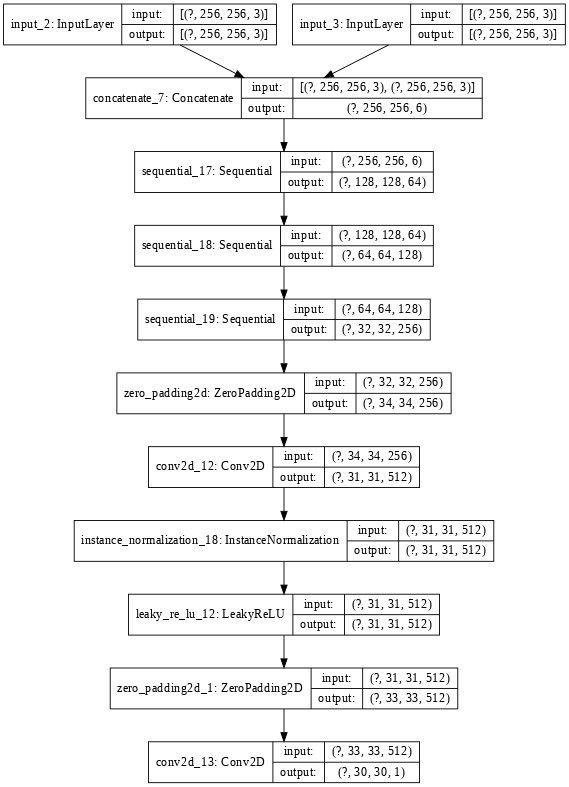

In [23]:
example_dis = Discriminator()
tf.keras.utils.plot_model(example_dis, show_shapes=True, dpi=64)

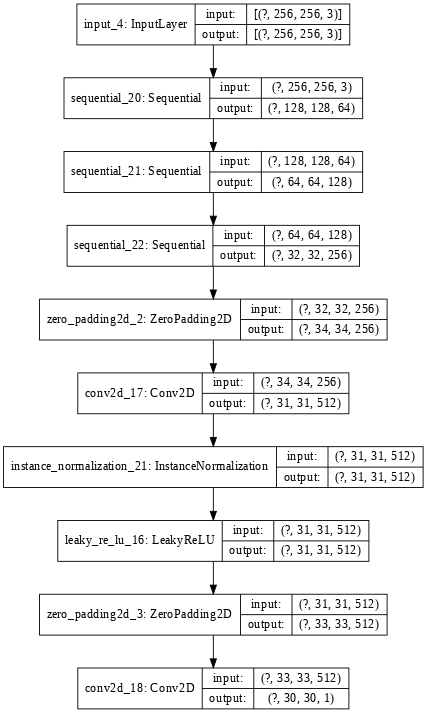

In [24]:
example_dis_no_target = Discriminator(target=False)
tf.keras.utils.plot_model(example_dis_no_target, show_shapes=True, dpi=64)

## Combined Model

In CycleGAN, there are two generators and two discriminators being trained.

* Generator (`G`) is trained to transform image X to image Y. (G: X -> Y)
* Generator (`F`) is trained to transform image Y to image X. (F: Y -> X)
* Discriminator ($D_x$) is trained to discriminate image X from the generated X (`F(Y)`).
* Discriminator ($D_y$) is trained to discriminate image Y from the generated Y (`G(X)`).


![](https://www.tensorflow.org/tutorials/generative/images/cyclegan_model.png)
- refer to Tensorflow.org (2020)

In our case, 
* the Generator G transform horse to zebra
* the Generator F does from zebra to horse
* the Discriminator $D_x$ tells the horse real or not
* the Discriminator $D_y$ tells the zebra real or not


In [25]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator(target=False)
discriminator_y = Discriminator(target=False)

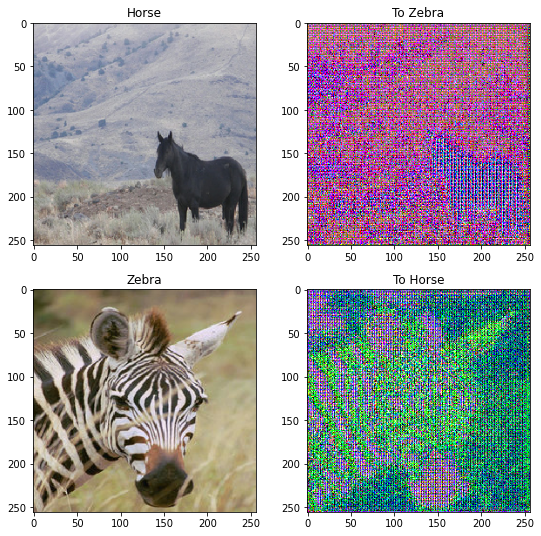

In [26]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
img_titles = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

plt.figure(figsize=(9, 9))
contrast = 8
for idx in range(len(imgs)):
  plt.subplot(2, 2, idx+1)
  plt.title(img_titles[idx])

  if idx % 2 == 0:
    plt.imshow(imgs[idx][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[idx][0] * 0.5 * contrast + 0.5)
plt.show()

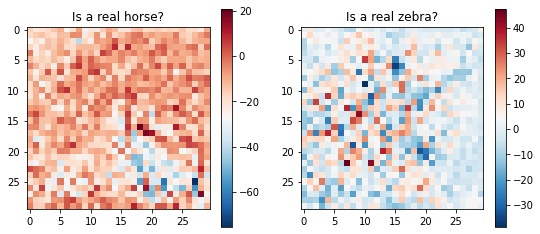

In [27]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.title("Is a real horse?")
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Is a real zebra?")
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap="RdBu_r")
plt.colorbar()

plt.show()

# Loss Function

In CycleGAN, there is no paired data to train on, hence there is no guarantee a mapping from the input X to the output Y is meaningful during training. Therefore the author proposes the cycle consistency loss function to make the network be trained in the correct mapping.

## Generator and Discriminator

The discriminator and the generator loss object are similar to the Pix2Pix.

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real, generated):
  real_loss = loss_object(tf.ones_like(real), real)
  generated_loss = loss_object(tf.zeros_like(generated), generated)
  total_loss = real_loss + generated_loss
  return total_loss

In [30]:
def generator_loss(generated):
  trick_loss = loss_object(tf.ones_like(generated), generated)
  return trick_loss

## Cycle Consistency Loss

**`Cycle Consistency` means the output from regenerated should be closer to the original input.** For instance, a sentence is translated from English to Chinese, translate this Chinese sentence back into English one, and this retranslated sentence should be the same as the original one.

In cycle consistency loss,

* An input image $X$ is transformed to the generated image $\hat{Y}$ via the Generator `G` (or $Y = G(X)$), and this image $\hat{Y}$ is further transformed into the cycle image $\hat{X}$ via the Generator `F`.
* We can look for the structure similarity via the `Mean Absolute Error` between $X$ and $\hat{X}$.

The above loss exists at both:

* `forward cycle consistency loss`: $X -> \hat{Y} = G(X) -> \hat{X} = F(G(X))$
* `backward cycle consistency loss`: $Y -> \hat{X} = F(Y) -> \hat{Y} = G(F(Y))$

![](https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png)
- refer to Tensorflow.org (2020)

In [31]:
LAMBDA = 10

In [32]:
def cycle_loss(real_image, cycled_image):
  cycle_loss_value = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * cycle_loss_value

## Identity Loss

Another loss is called `identity loss`. The above Generator $G$ transforms $Y$ to $Y$. If pass $Y$ through the Generator `G`, the generated $\hat{Y}$ should be identical to $Y$.

In [33]:
def identity_loss(real_image, same_image):
  identity_loss_value = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * identity_loss_value

## Optimizators

In [34]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training

## Checkpoints

In [35]:
ckpt_path = "./ckpts/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Load the latest checkpoiint.")

## Steps

In [36]:
def generated_image(model, test_inputs):
  test_outputs = model(test_inputs, training=True)

  images = [test_inputs[0], test_outputs[0]]
  titles = ["Input", "Prediction"]

  plt.figure(figsize=(11, 5))

  for idx in range(len(titles)):
    plt.subplot(1, 2, idx+1)
    plt.imshow(images[idx] * 0.5 + 0.5)
    plt.title(titles[idx])
    plt.axis("off")

  plt.show()

In [37]:
@tf.function
def train_step(real_x, real_y):
  # persistent=True: gradients are used more than one time
  with tf.GradientTape(persistent=True) as tape:
    # CycleGAN relations
    gen_y = generator_g(real_x, training=True)
    cyc_x = generator_f(gen_y, training=True)  # cycle consistency loss

    gen_x = generator_f(real_y, training=True)
    cyc_y = generator_g(gen_x, training=True)  # cycle consistency loss

    same_x = generator_f(real_x, training=True)  # identity loss
    same_y = generator_g(real_y, training=True)  # identity loss

    dis_real_x = discriminator_x(real_x, training=True)
    dis_gen_x = discriminator_x(gen_x, training=True)

    dis_real_y = discriminator_y(real_y, training=True)
    dis_gen_y = discriminator_y(gen_y, training=True)

    # loss
    cycle_consistency_loss = cycle_loss(real_x, cyc_x) + cycle_loss(real_y, cyc_y)    

    generator_g_adversarial_loss = generator_loss(dis_gen_y)
    generator_g_identity_loss = identity_loss(real_y, same_y)

    generator_f_adversarial_loss = generator_loss(dis_gen_x)
    generator_f_identity_loss = identity_loss(real_x, same_x)

    total_generator_g_loss = generator_g_adversarial_loss + cycle_consistency_loss + generator_g_identity_loss
    total_generator_f_loss = generator_f_adversarial_loss + cycle_consistency_loss + generator_f_identity_loss

    discriminator_x_loss = discriminator_loss(dis_real_x, dis_gen_x)
    discriminator_y_loss = discriminator_loss(dis_real_y, dis_gen_y)

  # calculate the gradients
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

  # apply the gradients
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [38]:
def fit(epochs):
  for epoch in range(epochs):
    __startTime = time.time()

    n = 1
    for real_x, real_y in tf.data.Dataset.zip((train_horses, train_zebras)):
      train_step(real_x, real_y)
      if n % 100 == 0: print('.', end="")
      n += 1
    
    clear_output(wait=True)
    # use the constant image for a clear view
    generated_image(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
      ckpt_manager.save()
      print("Save the checkpoint ath epoch {}.".format(epoch + 1))
    
    print("Epoch {} took {} seconds.".format(epoch + 1, time.time() - __startTime))

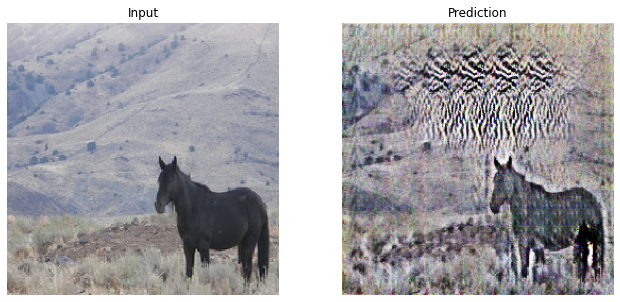

Save the checkpoint ath epoch 40.
Epoch 40 took 846.9172785282135 seconds.


In [39]:
EPOCHS = 40

fit(EPOCHS)